---
## Data Driven Modeling WS24/25
### Milestone 4 - Data Modelling
### by Ole Berg, Kristan Böttjer and Lennard Feuerbach
---

### Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score

from fcmeans import FCM

import plotly.express as px

### Loading the data preperation notebook

76.67% of rows have industries that are not relevant


C:\Users\lenna\AppData\Local\Temp\ipykernel_6784\628047844.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rates = gdp_per_industry.pct_change(axis=1)


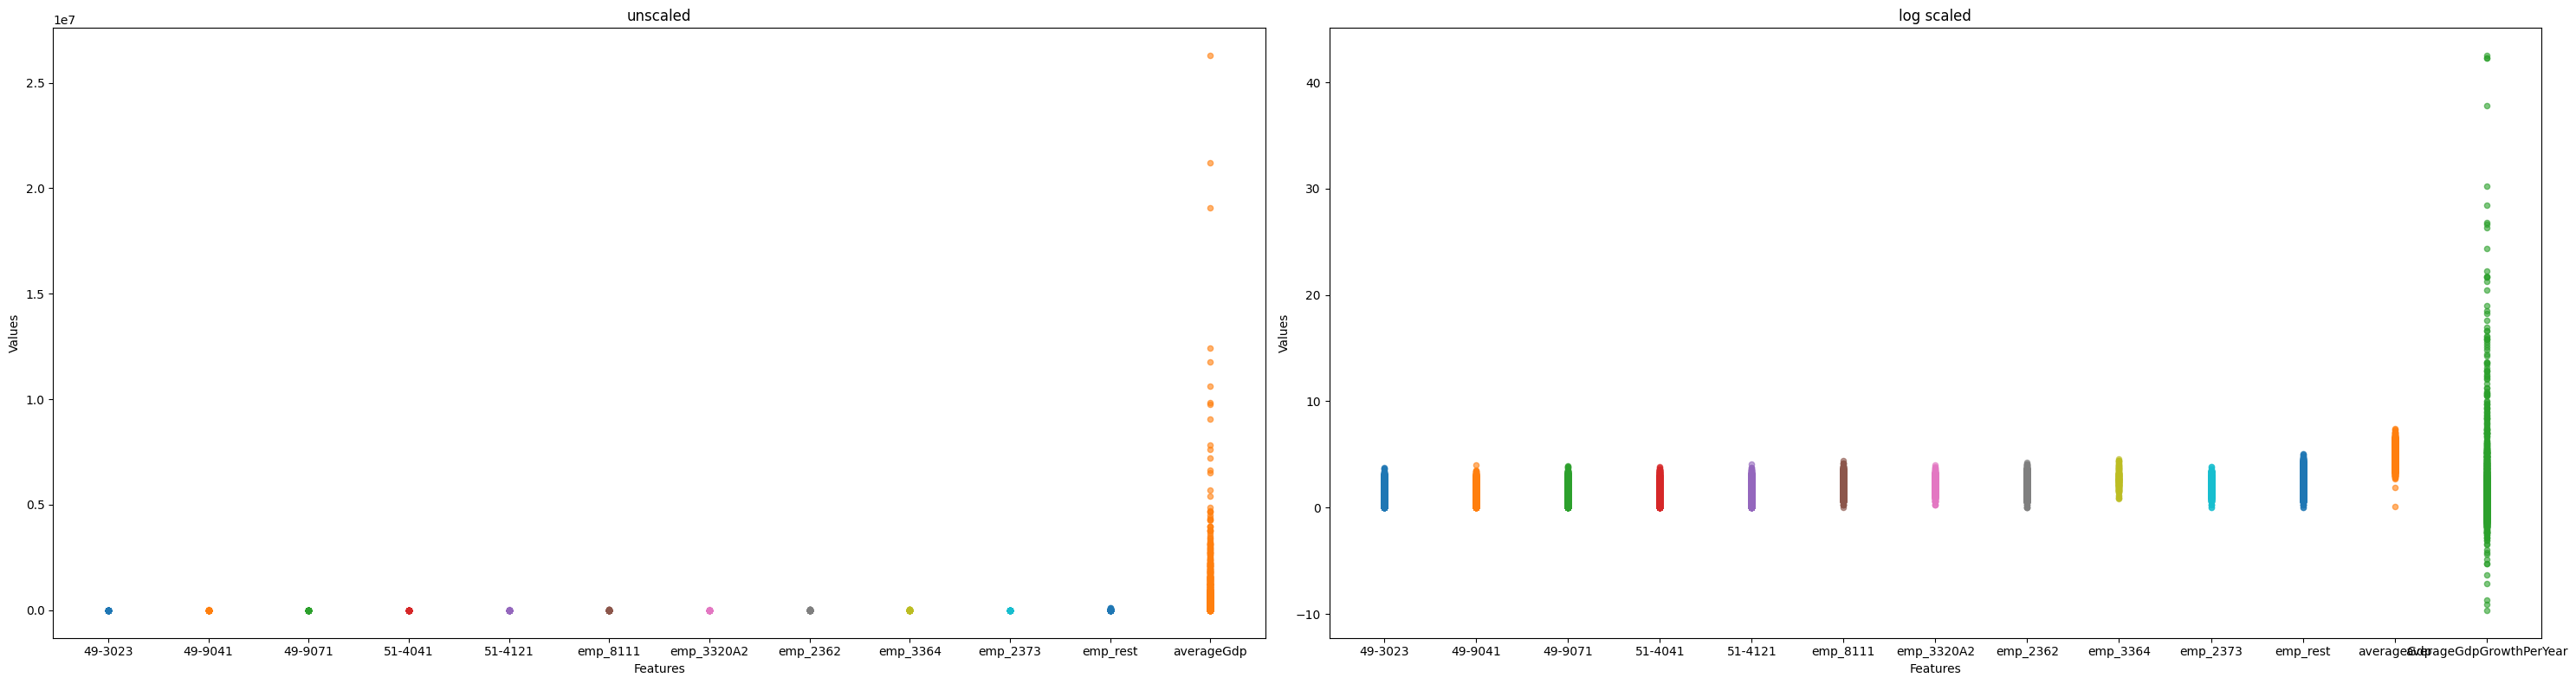

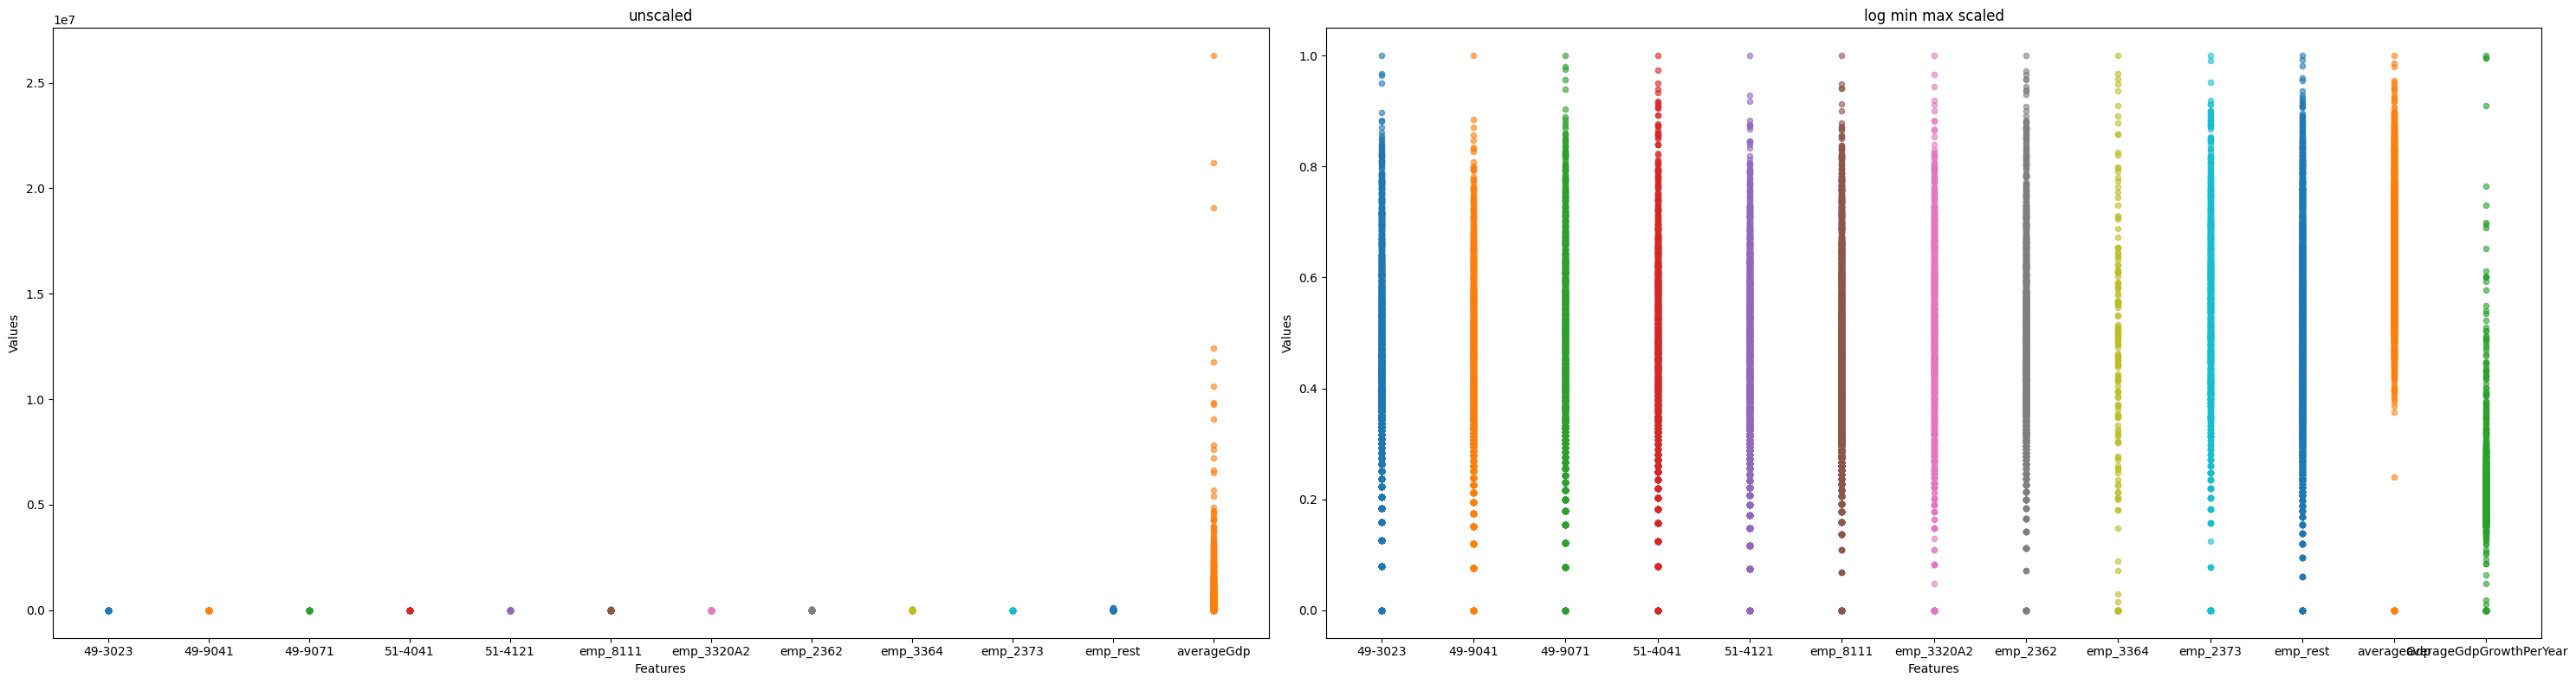

In [2]:
%run milestone_3_data_preperation_combined.ipynb

### Parameters

In [3]:
dimensions = 2
min_n_clusters = 3
max_n_clusters = 20
seed = 42

# Params which are not really neccessary anymore, since grid search is used
n_opt_clusters = 12 
min_samples = 20
eps = 5

### Dimension Reduction using t-SNE

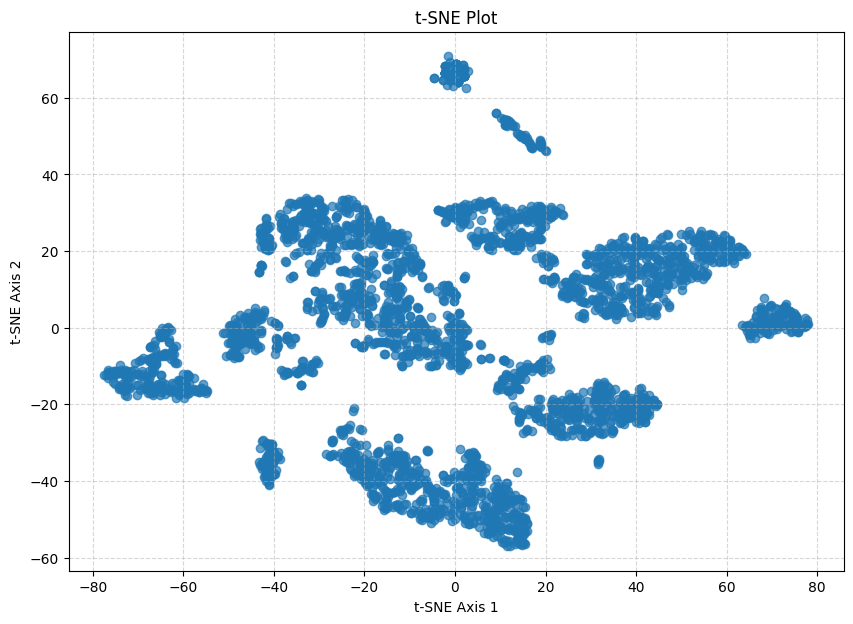

In [4]:
if dimensions == 2:
    # Using the t-SNE algorithm to reduce the dimensionality of the data to 2D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(master_df_scaled)

    # Adding the t-SNE results to the master dataframe
    master_df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])

    # Plotting the t-SNE results
    plt.figure(figsize=(10, 7))
    plt.scatter(master_df_tsne['tsne-2d-one'], master_df_tsne['tsne-2d-two'], alpha=0.7)
    plt.title('t-SNE Plot')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

elif dimensions == 3:
    # Using the t-SNE algorithm to reduce the dimensionality of the data to 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(master_df_scaled)

    # Adding the t-SNE results to the master dataframe
    master_df_tsne = pd.DataFrame(tsne_results, columns=['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three'])

    # 3d scatter plot
    fig = px.scatter_3d(
        master_df_tsne,
        x='tsne-3d-one',
        y='tsne-3d-two',
        z='tsne-3d-three',
        title="3D t-SNE Visualization",
        labels={
            "tsne-3d-one": "t-SNE Axis 1",
            "tsne-3d-two": "t-SNE Axis 2",
            "tsne-3d-three": "t-SNE Axis 3"
        },
        opacity=0.7
    )

    fig.update_traces(marker=dict(size=5))
    fig.update_layout(
        scene=dict(
            xaxis_title="t-SNE Axis 1",
            yaxis_title="t-SNE Axis 2",
            zaxis_title="t-SNE Axis 3"
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

### Helper functions

#### Visualization

In [5]:
#TODO: Adjusting the oppacity is missing, also no centroids are shown
def visualize_3d_clusters_fcm(model, df, name):
    # Convert DataFrame to NumPy array
    x = df.values

    # Fit the FCM model and get required outputs
    model.fit(x)
    fcm_centers = model.centers
    fcm_membership = model.u
    fcm_labels = model.predict(x)  # Discrete cluster labels

    # Add cluster labels to the DataFrame
    temp_df = df.copy()
    temp_df['Cluster'] = fcm_labels

    # Create a 3D scatter plot
    fig = px.scatter_3d(
        temp_df,
        x=df.columns[0],
        y=df.columns[1],
        z=df.columns[2],
        color='Cluster',
        title=f"3D {name} clustering with {len(set(fcm_labels))} clusters",
    )

    # Update marker size and layout
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(
        scene=dict(
            xaxis_title=df.columns[0],
            yaxis_title=df.columns[1],
            zaxis_title=df.columns[2]
        ),
        height=700,
        width=900
    )

    # Show the plot
    fig.show()

def visualize_2d_clusters_fcm(model, df, name):
    # Convert DataFrame to NumPy array
    x = df.values

    # Fit the FCM model and get required outputs
    model.fit(x)
    fcm_centers = model.centers
    fcm_membership = model.u
    fcm_labels = model.predict(x)  # Discrete cluster labels

    # Normalize alpha values for transparency
    max_membership = np.max(fcm_membership, axis=1)
    alpha_norm = Normalize(vmin=0, vmax=1)
    scatter_alpha = alpha_norm(max_membership)

    # Create plot
    plt.figure(figsize=(8, 6))

    # Scatter plot for each cluster
    colors = plt.cm.Set1(fcm_labels / max(fcm_labels))
    for i in range(len(x)):
        plt.scatter(x[i, 0], x[i, 1], color=colors[i], alpha=scatter_alpha[i])

    # Plot cluster centers
    plt.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker="+", s=100, c="black", label='centroid')

    plt.title(f"2D {name} clustering with {len(set(fcm_labels))} clusters")
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_clusters(model, df, dims, name):
    if isinstance(model, FCM):  # Check if the model is Fuzzy C-Means
        if dims == 2:
            visualize_2d_clusters_fcm(model, df, name)
        elif dims == 3:
            visualize_3d_clusters_fcm(model, df, name)
    else:  # Handle other clustering models
        #TODO: Add centroids
        clusters = model.fit_predict(df)
        columns = df.columns

        if dims == 2:
            # 2D Scatter plot
            plt.scatter(df[columns[0]], df[columns[1]], c=clusters, s=10)
            plt.title(f"2D {name} clustering with {len(set(clusters))} clusters")
            plt.xlabel(columns[0])
            plt.ylabel(columns[1])
            plt.show()

        elif dims == 3:
            #TODO: Add centroids
            # Add cluster labels to the DataFrame
            temp_df = df.copy()
            temp_df['Cluster'] = clusters

            # Create a 3D scatter plot
            fig = px.scatter_3d(
                temp_df,
                x=columns[0],
                y=columns[1],
                z=columns[2],
                color='Cluster',
                title=f"3D {name} clustering with {len(set(clusters))} clusters",
            )

            # Update marker size and layout
            fig.update_traces(marker=dict(size=3))
            fig.update_layout(
                scene=dict(
                    xaxis_title=columns[0],
                    yaxis_title=columns[1],
                    zaxis_title=columns[2]
                ),
                height=700,
                width=900
            )

            # Show the plot
            fig.show()

#### Grid-Search

In [6]:
def rank_models(results):
        """
        Rank models based on Silhouette and Davies-Bouldin scores and compute mean ranks.

        Parameters:
        - results (list of dict): A list containing parameters and individual scores for models.

        Returns:
        - DataFrame: Results with ranks and mean ranks.
        """
        results_df = pd.DataFrame(results)
        results_df['silhouette_rank'] = results_df['silhouette_score'].rank(ascending=False, method='min')
        results_df['davies_bouldin_rank'] = results_df['davies_bouldin_score'].rank(ascending=True, method='min')
        results_df['mean_rank'] = results_df[['silhouette_rank', 'davies_bouldin_rank']].mean(axis=1)
        return results_df

def grid_search(X, method, param_grid):
    """
    Perform a grid search to find the best clustering model.

    Parameters:
    - X (DataFrame): The dataset.
    - method (object): Clustering method class (e.g., KMeans).
    - param_grid (dict): Dictionary of parameters to try, where keys are
        parameter names and values are lists of values to iterate over.

    Returns:
    - best_model: The clustering model with the best mean rank.
    - best_params: The parameters of the best model.
    - results_df (DataFrame): DataFrame containing the results of the search.
    """
    import itertools

    param_names = list(param_grid.keys())
    param_combinations = list(itertools.product(*param_grid.values()))

    results = []

    for param_combination in param_combinations:
        params = dict(zip(param_names, param_combination))
        model = method(**params)
        if (isinstance(model, FCM)):
            model.fit(X.to_numpy())
            # Membership probabilities
            memberships = model.u
            # Hard 
            # labels based on maximum membership probability
            labels = np.argmax(memberships, axis=1)
        else:
            labels = model.fit_predict(X)

        if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)
            
        else :
            silhouette = -1
            davies_bouldin = np.inf
        results.append({
            **params,
            'silhouette_score': silhouette,
            'davies_bouldin_score': davies_bouldin
        }) 
            
    results_df = rank_models(results)
    results_df = results_df.sort_values('mean_rank')
    best_row = results_df.loc[results_df['mean_rank'].idxmin()]
    best_params = best_row[param_names].to_dict()
    return best_params, results_df

### Clustering

#### Calculating the best amount of clusters by using KMeans

In [7]:
k_means_params_dict = {
    'n_clusters': range(min_n_clusters, max_n_clusters),
    'n_init': [20],
    'random_state': [seed]
}

best_params_kmeans, kmeans_result_df = grid_search(master_df_tsne, KMeans, k_means_params_dict)

<Figure size 1500x600 with 0 Axes>

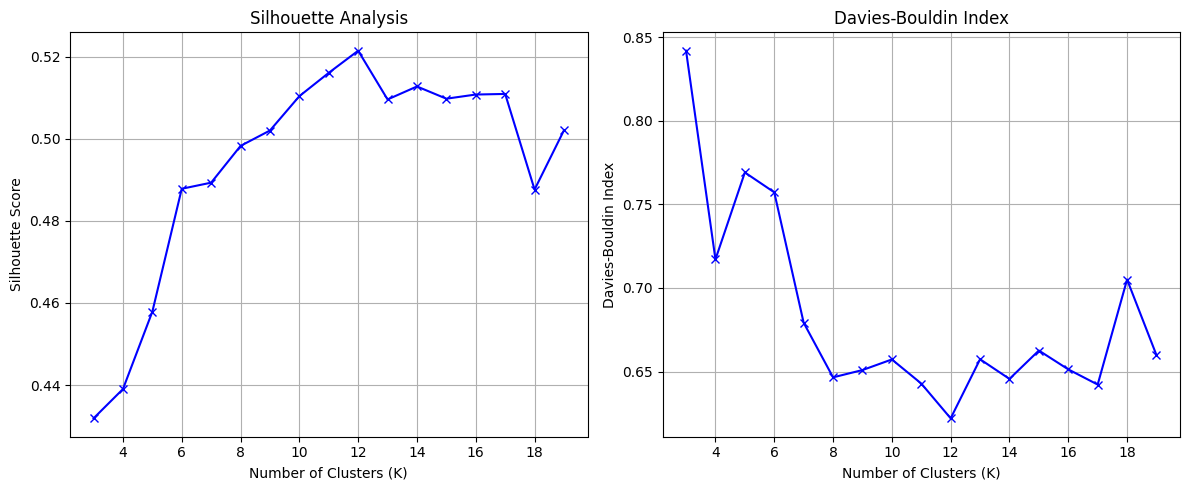

{'n_clusters': 12.0, 'n_init': 20.0, 'random_state': 42.0}

In [8]:
# Plot distortions
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot silhouette scores
results_sorted_by_clusters = kmeans_result_df.sort_values('n_clusters')

# Silhouette Analysis
axes[0].plot(results_sorted_by_clusters['n_clusters'], results_sorted_by_clusters['silhouette_score'], 'bx-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Analysis')
axes[0].grid(True)

# Davies-Bouldin Index
axes[1].plot(results_sorted_by_clusters['n_clusters'], results_sorted_by_clusters['davies_bouldin_score'], 'bx-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True)
plt.tight_layout()
plt.show()

display(best_params_kmeans)

#### k-means

In [9]:
# Old clustering with the optimal number of clusters based uopn the silhouette score
# visualize_clusters(KMeans(n_clusters=n_opt_clusters, n_init=10, random_state=42), master_df_tsne, dimensions, "KMeans")

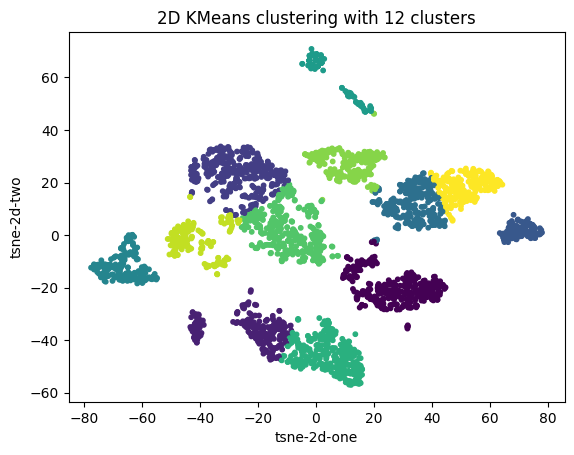

In [10]:
visualize_clusters(KMeans(n_clusters=int(best_params_kmeans['n_clusters']), n_init=10, random_state=42), master_df_tsne, dimensions, "KMeans")

#### DBSCAN

In [11]:
# Old clustering with the optimal number of clusters based uopn the silhouette score
# visualize_clusters(DBSCAN(eps=eps, min_samples=min_samples), master_df_tsne, dimensions, "DBSCAN")

{'eps': 5.000000000000002, 'min_samples': 26.0}

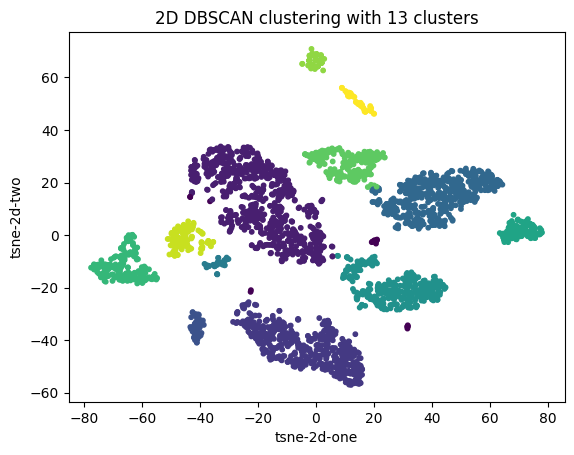

In [12]:
dbscan_params_dict = {
    'eps': np.arange(3, 7, 0.2),
    'min_samples':range(3,30),
}

bet_params_dbscan, dbscan_result_df = grid_search(master_df_tsne, DBSCAN, dbscan_params_dict)
display(bet_params_dbscan)
visualize_clusters(DBSCAN(eps=bet_params_dbscan['eps'], min_samples=int(bet_params_dbscan['min_samples'])), master_df_tsne, dimensions, "DBSCAN")

#### Hierarchical Clustering

In [13]:
# Old clustering with the optimal number of clusters based uopn the silhouette score
# visualize_clusters(AgglomerativeClustering(n_clusters=n_opt_clusters), master_df_tsne, dimensions, "Agglomerative Clustering")

{'n_clusters': 11.0}

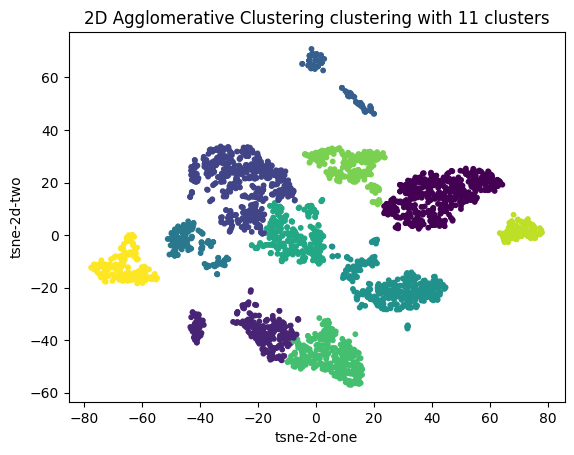

In [14]:
agglo_params_dict = {
    'n_clusters':range(min_n_clusters, max_n_clusters),
}

bet_params_agglo, agglo_result_df = grid_search(master_df_tsne, AgglomerativeClustering, agglo_params_dict)
display(bet_params_agglo)
visualize_clusters(AgglomerativeClustering(n_clusters = int(bet_params_agglo['n_clusters'])), master_df_tsne, dimensions, "Agglomerative Clustering")

#### Fuzzy C-Means

In [15]:
# Old clustering with the optimal number of clusters based uopn the silhouette score
# visualize_clusters(FCM(n_clusters=n_opt_clusters, random_state=42), master_df_tsne, dimensions, "Fuzzy C-Means")

{'n_clusters': 17.0, 'random_state': 42.0}

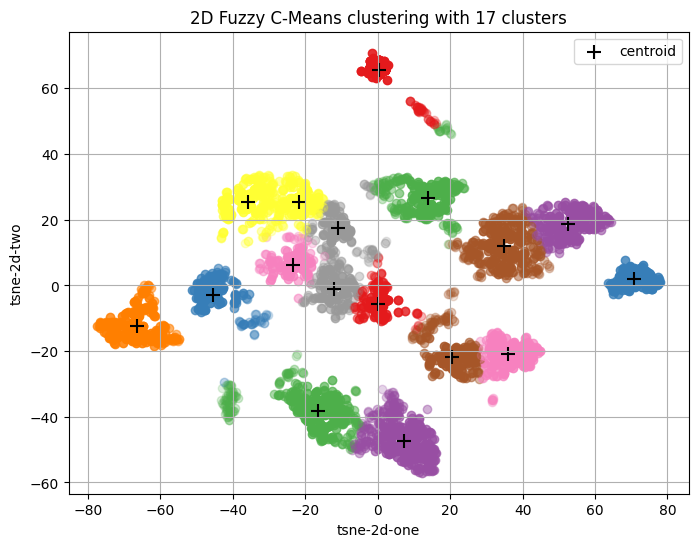

In [16]:
fcm_params_dict = {
    'n_clusters':range(min_n_clusters, max_n_clusters),
    'random_state': [seed]
}

bet_params_fcm, fcm_result_df = grid_search(master_df_tsne, FCM, fcm_params_dict)
display(bet_params_fcm)
visualize_clusters(FCM(n_clusters=bet_params_fcm['n_clusters']), master_df_tsne, dimensions, "Fuzzy C-Means")